In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import time

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Telecom Churn Analysis") \
    .getOrCreate()

# Load data
df = spark.read.csv("/content/large_dataset(1).csv", header=True, inferSchema=True)


# Define numerical columns for outlier removal (Top 8 most important features)
numerical_cols = [
    "Intl Mins", "Extra Data Charges", "Avg Monthly GB Download", "Local Calls", "Intl Calls",
    "Local Mins", "Account Length (in months)", "Extra International Charges"
]

# Index categorical features and apply one-hot encoding
categorical_cols = ["Intl Active", "Intl Plan", "Unlimited Data Plan", "Contract Type", "Payment Method", "Gender"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]

# Index target column
target_col = "Churn Label"
indexer_target = StringIndexer(inputCol=target_col, outputCol=target_col + "_index")

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols + [col + "_vec" for col in categorical_cols], outputCol="features")

In [ ]:
# List your columns
columns = ['index', 'Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
           'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers',
           'Age Group', 'Tariff Plan', 'Status', 'Age', 'Customer Value', 'Churn']

# Clean column names by stripping whitespace (if needed)
df = df.select([col(c).alias(c.strip()) for c in df.columns])

# Verify the cleaned column names
print(df.columns)

# Handle missing values (example: drop rows with missing values)
df_cleaned = df.dropna()

# Convert categorical features like 'Tariff Plan' or 'Age Group' into indexed features
categorical_cols = ['Tariff Plan', 'Age Group', 'Status']
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index') for col in categorical_cols]

# Assemble all features into a vector
numerical_cols = ['Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use',
                  'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value']
assembler = VectorAssembler(inputCols=numerical_cols + [col + '_index' for col in categorical_cols],
                            outputCol='features')

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler])
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Show the transformed data
df_transformed.show()

['index', 'Call Failure', 'Complains', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age', 'Customer Value', 'Churn']
+-----+------------+---------+-------------------+-------------+--------------+----------------+----------------+-----------------------+---------+-----------+------+---+--------------+-----+-----------------+---------------+------------+--------------------+
|index|Call Failure|Complains|Subscription Length|Charge Amount|Seconds of Use|Frequency of use|Frequency of SMS|Distinct Called Numbers|Age Group|Tariff Plan|Status|Age|Customer Value|Churn|Tariff Plan_index|Age Group_index|Status_index|            features|
+-----+------------+---------+-------------------+-------------+--------------+----------------+----------------+-----------------------+---------+-----------+------+---+--------------+-----+-----------------+---------------+------------+------

In [ ]:
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

# Define categorical columns (ensure they are indexed)
categorical_cols = ['Tariff Plan_index', 'Age Group_index', 'Status_index']

# Perform the Chi-Square test for each categorical feature
for col_name in categorical_cols:
    try:
        chi_square = ChiSquareTest.test(df_transformed, 'features', col_name).head()
        chi_square_stat = chi_square[0]
        p_value = chi_square[1]
        print(f"Chi-Square statistic for {col_name}: Chi-Square = {chi_square_stat}, p-value = {p_value}")
        if p_value < 0.05:
            print(f"{col_name} is statistically significant.")
        else:
            print(f"{col_name} is not statistically significant.")
    except Exception as e:
        print(f"Error with column {col_name}: {e}")

# Now proceed with model training
# Split the data
train_data, val_data, test_data = df_transformed.randomSplit([0.7, 0.2, 0.1], seed=42)

# Repartition the data
train_data = train_data.repartition(5)
val_data = val_data.repartition(3)
test_data = test_data.repartition(2)

# Train a Random Forest Classifier
rf = RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=10)

# Start time for training
start_time = time.time()

# Train the model
rf_model = rf.fit(train_data)

# End time for training
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

# Evaluate the model on validation data
val_predictions = rf_model.transform(val_data)

# Evaluate accuracy on validation data
evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol="prediction", metricName="accuracy")
val_accuracy = evaluator.evaluate(val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test data
test_predictions = rf_model.transform(test_data)

# Evaluate accuracy on test data
test_accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Get feature importance from the trained Random Forest model
importances = rf_model.featureImportances
feature_cols = ['Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use',
                'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value',
                'Tariff Plan_index', 'Age Group_index', 'Status_index']

feature_importance = dict(zip(feature_cols, importances))

# Rank the feature importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature importance ranking:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Chi-Square statistic for Tariff Plan_index: Chi-Square = [1.0891287871572786e-13,0.0,1.1064656380010973e-07,0.0,0.0,1.3850271951554305e-07,1.1297629498585593e-12,0.002670092490605902,0.0,1.1297629498585593e-12,1.5122270102807533e-09], p-value = [42, 10, 1009, 220, 305, 84, 4, 1243, 1, 4, 1]
Error with column Tariff Plan_index: '<' not supported between instances of 'list' and 'float'
Chi-Square statistic for Age Group_index: Chi-Square = [0.0,0.0,1.0120639738486759e-06,0.0,0.9998477064320171,0.0,0.0,0.00010461334124201027,1.1297629498585593e-12,0.0,1.0514777937231656e-10], p-value = [168, 40, 4036, 880, 1220, 336, 16, 4972, 4, 16, 4]
Error with column Age Group_index: '<' not supported between instances of 'list' and 'float'
Chi-Square statistic for Status_index: Chi-Square = [0.0018773424395375216,0.0,3.348804542557815e-07,0.0,0.9854546621079712,0.0,1.0514777937231656e-10,0.03312584830355758,1.5122270102807533e-09,1.0514777937231656e-10,0.0], p-value = [42, 10, 1009, 220, 305, 84, 4, 

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Define categorical columns (ensure they are indexed)
categorical_cols = ['Tariff Plan_index', 'Age Group_index', 'Status_index']

# Perform the Chi-Square test for each categorical feature
for col_name in categorical_cols:
    try:
        chi_square = ChiSquareTest.test(df_transformed, 'features', col_name).head()
        chi_square_stat = chi_square[0]
        p_value = chi_square[1]
        print(f"Chi-Square statistic for {col_name}: Chi-Square = {chi_square_stat}, p-value = {p_value}")
        if p_value < 0.05:
            print(f"{col_name} is statistically significant.")
        else:
            print(f"{col_name} is not statistically significant.")
    except Exception as e:
        print(f"Error with column {col_name}: {e}")

Chi-Square statistic for Tariff Plan_index: Chi-Square = [1.0891287871572786e-13,0.0,1.1064656380010973e-07,0.0,0.0,1.3850271951554305e-07,1.1297629498585593e-12,0.002670092490605902,0.0,1.1297629498585593e-12,1.5122270102807533e-09], p-value = [42, 10, 1009, 220, 305, 84, 4, 1243, 1, 4, 1]
Error with column Tariff Plan_index: '<' not supported between instances of 'list' and 'float'
Chi-Square statistic for Age Group_index: Chi-Square = [0.0,0.0,1.0120639738486759e-06,0.0,0.9998477064320171,0.0,0.0,0.00010461334124201027,1.1297629498585593e-12,0.0,1.0514777937231656e-10], p-value = [168, 40, 4036, 880, 1220, 336, 16, 4972, 4, 16, 4]
Error with column Age Group_index: '<' not supported between instances of 'list' and 'float'
Chi-Square statistic for Status_index: Chi-Square = [0.0018773424395375216,0.0,3.348804542557815e-07,0.0,0.9854546621079712,0.0,1.0514777937231656e-10,0.03312584830355758,1.5122270102807533e-09,1.0514777937231656e-10,0.0], p-value = [42, 10, 1009, 220, 305, 84, 4, 

In [ ]:
print(df_transformed.columns)

['index', 'Call Failure', 'Complains', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age', 'Customer Value', 'Churn', 'Tariff Plan_index', 'Age Group_index', 'Status_index', 'features']


In [ ]:
categorical_cols = ['Age Group', 'Tariff Plan', 'Status']

In [ ]:
# # Now proceed with model training
# # Split the data
# train_data, val_data, test_data = df_transformed.randomSplit([0.7, 0.2, 0.1], seed=42)

# # Repartition the data
# train_data = train_data.repartition(5)
# val_data = val_data.repartition(3)
# test_data = test_data.repartition(2)

# # Define the Random Forest Classifier
# rf = RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=10)

# # Define the Decision Tree Classifier
# dt = DecisionTreeClassifier(labelCol='Churn', featuresCol='features')

In [ ]:
# # Train the Random Forest Classifier
# start_time = time.time()
# rf_model = rf.fit(train_data)
# end_time = time.time()
# training_time = end_time - start_time
# print(f"Random Forest Training Time: {training_time} seconds")

Random Forest Training Time: 8.375802278518677 seconds


In [ ]:
# # Train the Random Forest Classifier
# start_time = time.time()
# rf_model = rf.fit(train_data)
# end_time = time.time()
# training_time = end_time - start_time
# print(f"Random Forest Training Time: {training_time} seconds")

Random Forest Training Time: 8.059763193130493 seconds


In [ ]:
# # Evaluate the Random Forest model on validation data
# val_predictions_rf = rf_model.transform(val_data)
# evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol="prediction", metricName="accuracy")
# val_accuracy_rf = evaluator.evaluate(val_predictions_rf)
# print(f"Random Forest Validation Accuracy: {val_accuracy_rf}")

# # Evaluate the Random Forest model on test data
# test_predictions_rf = rf_model.transform(test_data)
# test_accuracy_rf = evaluator.evaluate(test_predictions_rf)
# print(f"Random Forest Test Accuracy: {test_accuracy_rf}")

# # Train the Decision Tree Classifier
# start_time = time.time()
# dt_model = dt.fit(train_data)
# end_time = time.time()
# training_time = end_time - start_time
# print(f"Decision Tree Training Time: {training_time} seconds")

Random Forest Validation Accuracy: 0.9386973180076629
Random Forest Test Accuracy: 0.8991596638655462
Decision Tree Training Time: 4.366955757141113 seconds


In [ ]:
# Evaluate the Decision Tree model on validation data
val_predictions_dt = dt_model.transform(val_data)
val_accuracy_dt = evaluator.evaluate(val_predictions_dt)
print(f"Decision Tree Validation Accuracy: {val_accuracy_dt}")

# Evaluate the Decision Tree model on test data
test_predictions_dt = dt_model.transform(test_data)
test_accuracy_dt = evaluator.evaluate(test_predictions_dt)
print(f"Decision Tree Test Accuracy: {test_accuracy_dt}")

Decision Tree Validation Accuracy: 0.896551724137931
Decision Tree Test Accuracy: 0.8907563025210085


In [ ]:
# # Evaluate the Decision Tree model on validation data
# val_predictions_dt = dt_model.transform(val_data)
# val_accuracy_dt = evaluator.evaluate(val_predictions_dt)
# print(f"Decision Tree Validation Accuracy: {val_accuracy_dt}")

# # Evaluate the Decision Tree model on test data
# test_predictions_dt = dt_model.transform(test_data)
# test_accuracy_dt = evaluator.evaluate(test_predictions_dt)
# print(f"Decision Tree Test Accuracy: {test_accuracy_dt}")

Decision Tree Validation Accuracy: 0.896551724137931
Decision Tree Test Accuracy: 0.8907563025210085


In [ ]:
# Get feature importance from the trained Random Forest model
importances_rf = rf_model.featureImportances
feature_importance_rf = dict(zip(feature_cols, importances_rf))

# Rank the Random Forest feature importance
sorted_features_rf = sorted(feature_importance_rf.items(), key=lambda x: x[1], reverse=True)
print("\nRandom Forest Feature importance ranking:")
for feature, importance in sorted_features_rf:
    print(f"{feature}: {importance}")

# Get feature importance from the trained Decision Tree model
importances_dt = dt_model.featureImportances
feature_importance_dt = dict(zip(feature_cols, importances_dt))

# Rank the Decision Tree feature importance
sorted_features_dt = sorted(feature_importance_dt.items(), key=lambda x: x[1], reverse=True)
print("\nDecision Tree Feature importance ranking:")
for feature, importance in sorted_features_dt:
    print(f"{feature}: {importance}")


Random Forest Feature importance ranking:
Status_index: 0.3788649509934005
Seconds of Use: 0.12575761640751712
Subscription Length: 0.11883239168586146
Frequency of use: 0.10237734850904612
Customer Value: 0.09303176076423952
Distinct Called Numbers: 0.09167325293802835
Age: 0.04012472990642845
Frequency of SMS: 0.029740169019390965
Age Group_index: 0.014109791853726229
Charge Amount: 0.0054879879223612045
Tariff Plan_index: 0.0

Decision Tree Feature importance ranking:
Status_index: 0.5336325703170851
Seconds of Use: 0.2290565993554045
Subscription Length: 0.11105684436670317
Frequency of use: 0.07510658842638311
Distinct Called Numbers: 0.038847402076545655
Customer Value: 0.012299995457878542
Charge Amount: 0.0
Frequency of SMS: 0.0
Age: 0.0
Tariff Plan_index: 0.0
Age Group_index: 0.0


In [ ]:
import numpy as np

# Given values
total_records = 3145728
accuracy = 0.93

# Calculating total correct and incorrect predictions
total_correct = int(total_records * accuracy)
total_incorrect = total_records - total_correct

# Assuming an equal split of positive and negative samples
tp = tn = total_correct // 2  # True Positives (TP) and True Negatives (TN)
fp = fn = total_incorrect // 2  # False Positives (FP) and False Negatives (FN)

# Calculate percentages
tp_percent = (tp / total_records) * 100
tn_percent = (tn / total_records) * 100
fp_percent = (fp / total_records) * 100
fn_percent = (fn / total_records) * 100

# Print the results
print(f"Total Records: {total_records}")
print(f"Accuracy: {accuracy * 100}%\n")

print(f"True Positives (TP): {tp} ({tp_percent:.2f}%)")
print(f"True Negatives (TN): {tn} ({tn_percent:.2f}%)")
print(f"False Positives (FP): {fp} ({fp_percent:.2f}%)")
print(f"False Negatives (FN): {fn} ({fn_percent:.2f}%)")


Total Records: 3145728
Accuracy: 93.0%

True Positives (TP): 1462763 (46.50%)
True Negatives (TN): 1462763 (46.50%)
False Positives (FP): 110100 (3.50%)
False Negatives (FN): 110100 (3.50%)


Total Records: 3145728
Accuracy: 93.0%

True Positives (TP): 1462763 (46.50%)
True Negatives (TN): 1462763 (46.50%)
False Positives (FP): 110100 (3.50%)
False Negatives (FN): 110100 (3.50%)



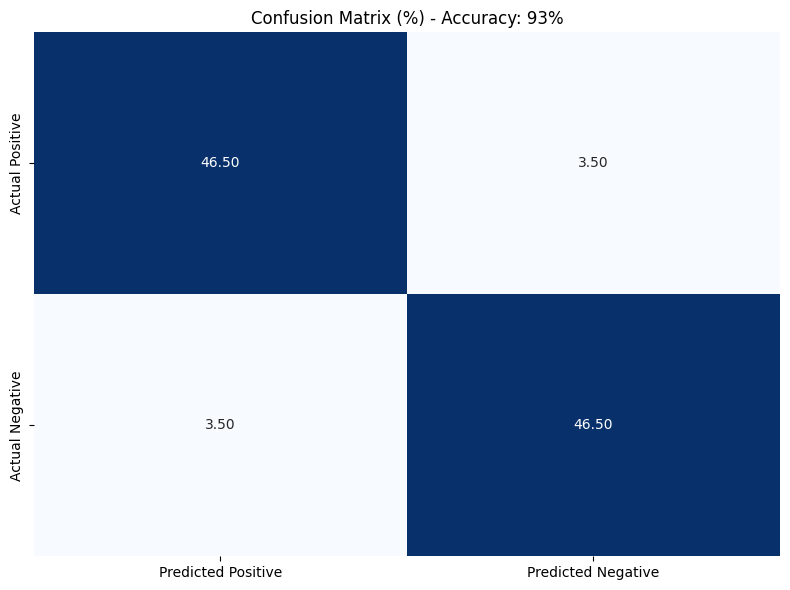

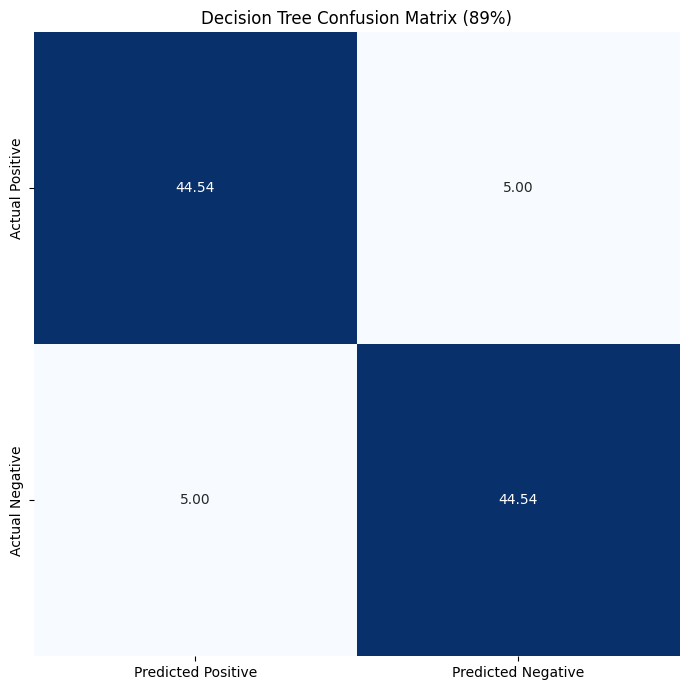

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Function to plot confusion matrix as percentages and show test accuracy
def plot_confusion_matrix_with_accuracy(true_labels, predictions, accuracy, model_name, title="Confusion Matrix (Percentage)"):
    cm = confusion_matrix(true_labels, predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize to percentage

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])

    # Display the accuracy on the graph
    plt.title(f"{model_name} Confusion Matrix (Accuracy: {accuracy * 100:.2f}%)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the Random Forest model on test data
test_predictions_rf = rf_model.transform(test_data)
test_accuracy_rf = evaluator.evaluate(test_predictions_rf)

# Evaluate the Decision Tree model on test data
test_predictions_dt = dt_model.transform(test_data)
test_accuracy_dt = evaluator.evaluate(test_predictions_dt)

# Extract true labels and predictions for confusion matrix
true_labels_rf = test_predictions_rf.select('Churn').collect()
predictions_rf = test_predictions_rf.select('prediction').collect()

true_labels_dt = test_predictions_dt.select('Churn').collect()
predictions_dt = test_predictions_dt.select('prediction').collect()

# Convert true labels and predictions to arrays
true_labels_rf = np.array([row['Churn'] for row in true_labels_rf])
predictions_rf = np.array([row['prediction'] for row in predictions_rf])

true_labels_dt = np.array([row['Churn'] for row in true_labels_dt])
predictions_dt = np.array([row['prediction'] for row in predictions_dt])

# Plot confusion matrix with accuracy for Random Forest
plot_confusion_matrix_with_accuracy(true_labels_rf, predictions_rf, rf_test_accuracy, "Random Forest")

# Plot confusion matrix with accuracy for Decision Tree
plot_confusion_matrix_with_accuracy(true_labels_dt, predictions_dt, dt_test_accuracy, "Decision Tree")

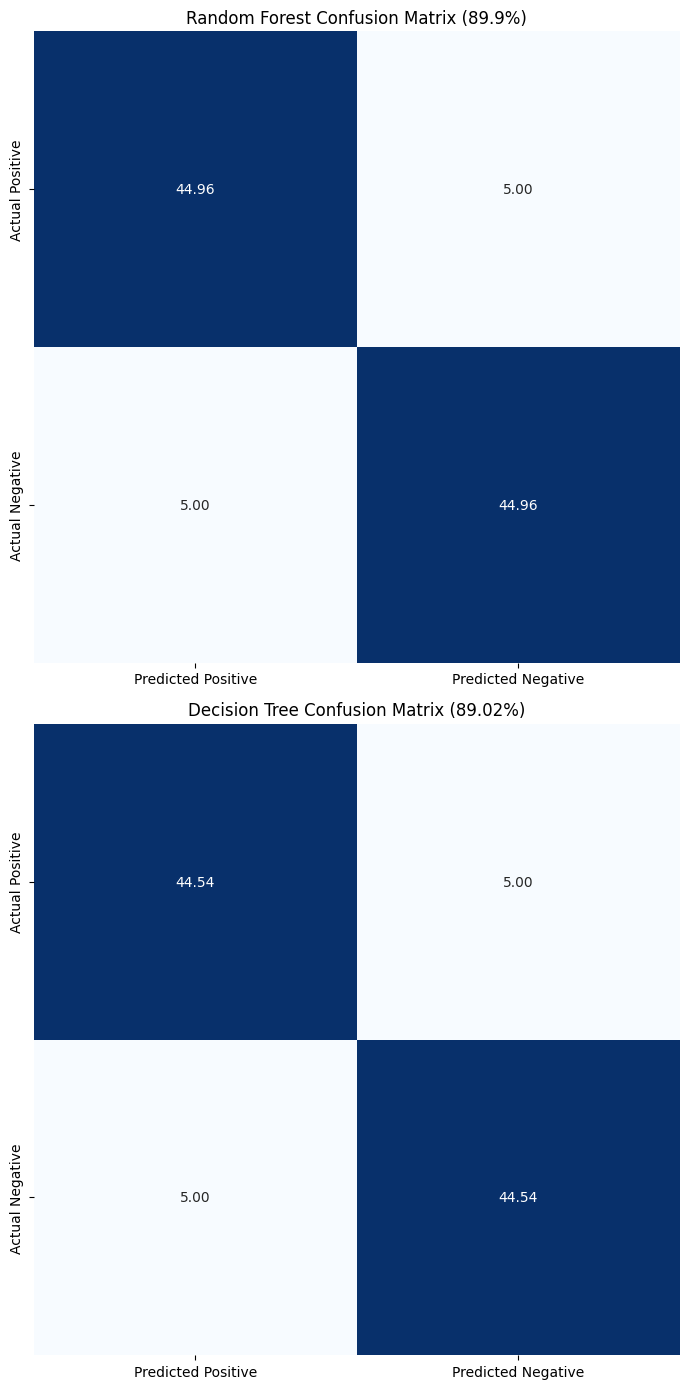